### Credit card fraud detection

#### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

from collections import Counter

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

#### 2. Data Analysis

In [2]:
df = pd.read_csv('card_transdata.csv')

In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [6]:
non_frauds_percent = round(df['fraud'].value_counts()[0] / len(df) * 100, 2)
frauds_percent = round(df['fraud'].value_counts()[1] / len(df) * 100, 2)

print(' Non Frauds : ', non_frauds_percent, '% of the dataset')
print(' Frauds : ', frauds_percent, '% of the dataset')

 Non Frauds :  91.26 % of the dataset
 Frauds :  8.74 % of the dataset


#### 3. EDA

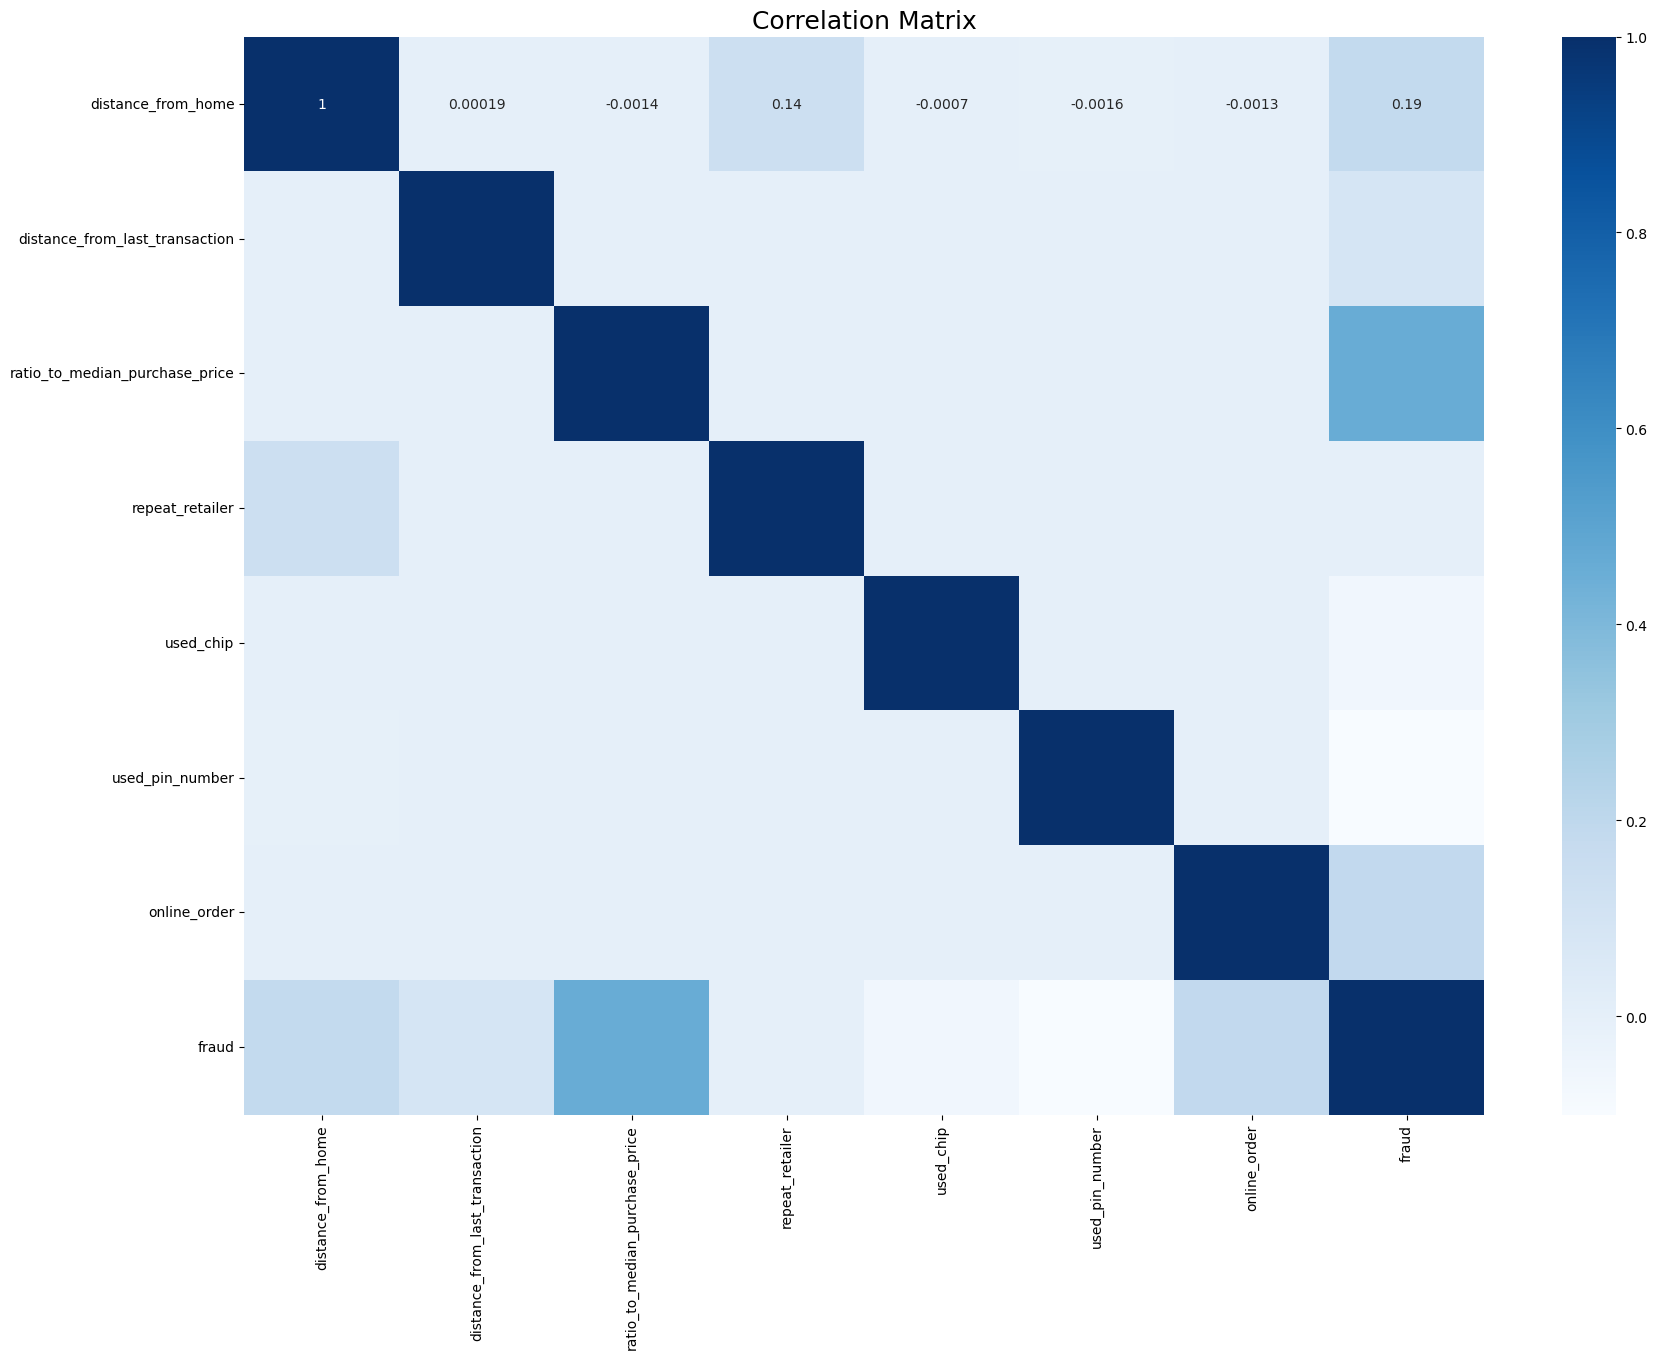

In [7]:
#1 **Plot correlation matrix**

corr = df.corr()

plt.figure(figsize=(20,14))
sns.heatmap(corr, cmap='Blues', xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.title('Correlation Matrix', fontsize=18)
plt.show()


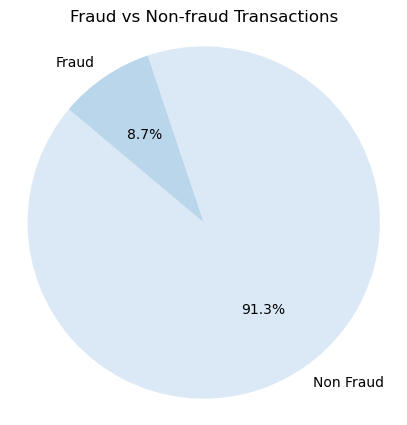

In [8]:
#2  **Display Fraud vs Non Fraud Transactions**
fraud_counts = df['fraud'].value_counts() #0=912597 and 1=87403

# fraud_counts 
fraud_counts.index = fraud_counts.index.map({0: 'Non Fraud', 1: 'Fraud'})
plt.figure(figsize=(5,5))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues'))
plt.title('Fraud vs Non-fraud Transactions')
plt.axis('equal')
plt.show()

### 4. Pre-processing

In [9]:
# Count for duplicate value
duplicate_count = df.duplicated().sum()
print('Count of duplicate rows: ', duplicate_count)

Count of duplicate rows:  0


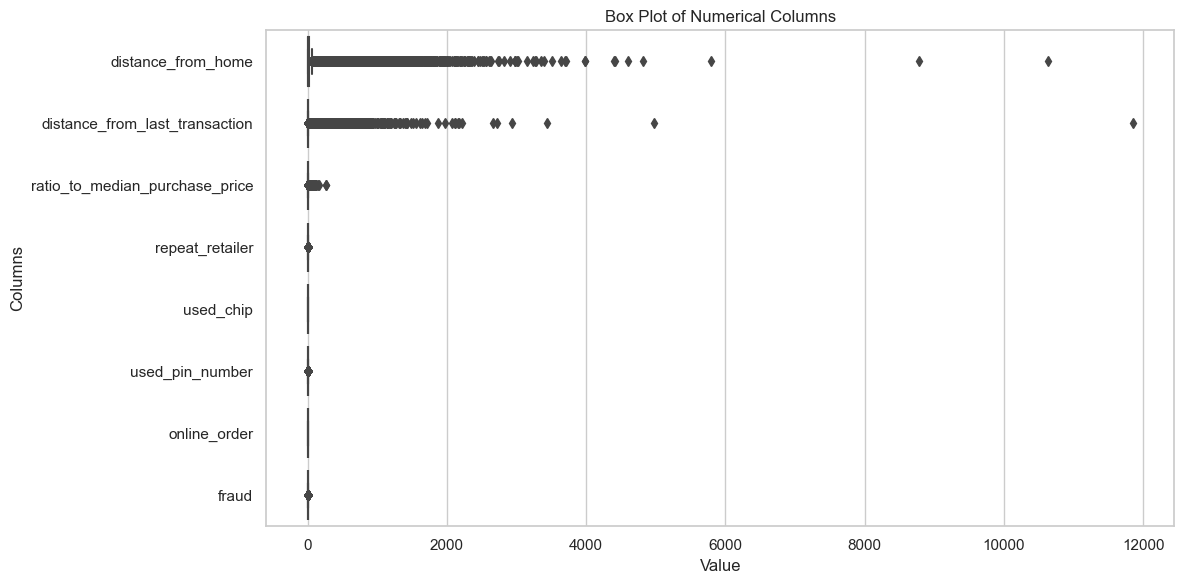

In [10]:
# Check for outliers

df = df.copy()

# Selecting numerical columns to plot

numerical_columns = df.select_dtypes(include = ['float64', 'int64']).columns
sns.set(style='whitegrid', palette='Blues_r')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns], orient="h")
plt.title('Box Plot of Numerical Columns')
plt.xlabel('Value')
plt.ylabel('Columns')
plt.tight_layout()

plt.show()

**Detecting and deleting outliers**

In [11]:
def IQR_method(df, n, features):
    outlier_list = []
    
    for column in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # print(Q1)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column], 75)
        # print(Q3)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        #Outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        
        # Appending the list of outliers
        outlier_list.extend(outlier_list_column)
        
    outlier_list = Counter(outlier_list)
    multiple_outliers = [k for k, v in outlier_list.items() if v > n]
        
    # print(multiple_outliers)
    print('Total number of deleted outliers:', len(multiple_outliers))
        
    return multiple_outliers
    
Outliers_IQR = IQR_method(df, 1, numerical_columns)    

Total number of deleted outliers: 141044


**Dropping outliers**

In [12]:
df_out = df.drop(Outliers_IQR, axis=0).reset_index(drop=True)
print("Total number after deleted outliers :", len(df_out))

Total number after deleted outliers : 858956


### 5. Splitting Data

In [13]:
# Consider 'fraud' column as target column

X = df_out.drop('fraud', axis=1)
y = df_out['fraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print("Train set:")
print("Total rows:", len(X_train))
print("Frauds:", y_train.sum())
print("Non Frauds:", (y_train == 0).sum())

print("\nTest set:")
print("Total rows:", len(X_test))
print("Frauds:", y_test.sum())
print("Non Frauds:", (y_test == 0).sum())

Train set:
Total rows: 601269
Frauds: 5288.0
Non Frauds: 595981

Test set:
Total rows: 257687
Frauds: 2266.0
Non Frauds: 255421


### 6. Feature Scaling
- Standardization (or scaling) is a preprocessing step that transforms data to have a mean of 0 and a standard deviation of 1 This ensures that all features contribute equally to the model training proces.

In [15]:
from sklearn.preprocessing import StandardScaler



In [16]:
# Function for scaling specific columns in a DataFrame
def Standard_Scaler(df, col_names):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[col_names] = scaler.fit_transform(df_scaled[col_names])
    
    return df_scaled

In [17]:
col_names= ['distance_from_home', 'distance_from_last_transaction',
           'ratio_to_median_purchase_price', 'repeat_retailer',
           'used_chip', 'used_pin_number', 'online_order']

In [18]:
# Apply standard scaler to x_train and x_test
X_train = Standard_Scaler(X_train, col_names)
X_test  = Standard_Scaler(X_test, col_names)

In [19]:
# Print to verify
print("X_train (Scaled) : \n")
print(X_train.head())

X_train (Scaled) : 

        distance_from_home  distance_from_last_transaction  \
634673           -0.406713                       -0.178884   
849056           -0.323700                       -0.062132   
169467            0.097783                        1.227639   
545813           -0.154584                       -0.190525   
642113           -0.242406                       -0.112600   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
634673                       -0.070717        -3.036433  -0.747623   
849056                        0.145639         0.329334   1.337573   
169467                       -0.625640         0.329334  -0.747623   
545813                       -0.467967         0.329334  -0.747623   
642113                        0.562374         0.329334  -0.747623   

        used_pin_number  online_order  
634673        -0.280844      0.768850  
849056        -0.280844     -1.300644  
169467        -0.280844      0.768850  
545813        -0.280844  

In [20]:
# Print to verify
print("X_test (Scaled) : \n")
print(X_test.head())

X_test (Scaled) : 

        distance_from_home  distance_from_last_transaction  \
359079           -0.402876                        0.144208   
193823           -0.410300                        0.315059   
386783           -0.359542                       -0.125003   
205397           -0.043316                        0.918884   
478120            6.331112                       -0.121041   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
359079                       -0.608053         0.328652  -0.744656   
193823                        0.108153         0.328652   1.342901   
386783                       -0.585419         0.328652  -0.744656   
205397                        0.150736         0.328652  -0.744656   
478120                       -0.722999         0.328652   1.342901   

        used_pin_number  online_order  
359079        -0.280242     -1.301918  
193823        -0.280242     -1.301918  
386783        -0.280242     -1.301918  
205397        -0.280242   

### 7. Resampling using SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
# initialize SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE oversampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after oversampling
print("Before Oversampling :", Counter(y_train))
print("After Oversampling :", Counter(y_train_resampled))

Before Oversampling : Counter({0.0: 595981, 1.0: 5288})
After Oversampling : Counter({0.0: 595981, 1.0: 595981})


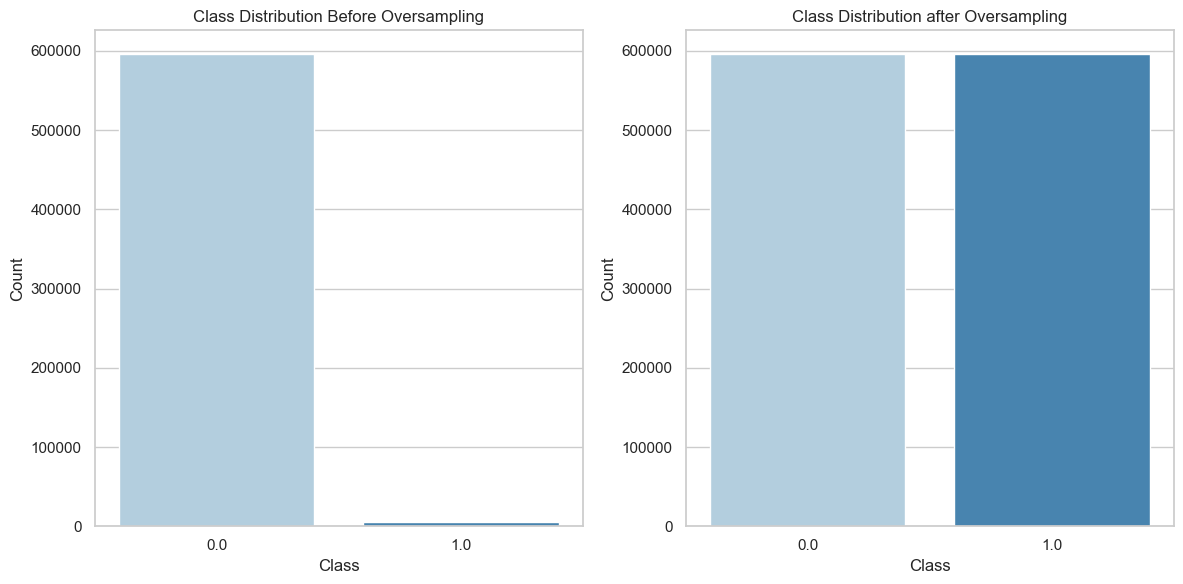

In [23]:
#EDA after resampling

before_counts = Counter(y_train)
after_counts = Counter(y_train_resampled)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='Blues')
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, palette='Blues')
plt.title('Class Distribution after Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### **8. Machine Learning Algorithm**

#### **8.1 K-Nearest Neighbors (KNN) algorithm**

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
# Initialize KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model on oversampled data
knn.fit(X_train_resampled, y_train_resampled)

y_pred = knn.predict(X_test)

accuracy_kn = knn.score(X_test, y_test)
accuracy_kn = accuracy_kn*100
print("\nKNN Accuracy: ", accuracy_kn)


KNN Accuracy:  99.73650203541506


In [28]:
from sklearn.metrics import confusion_matrix, precision_score, classification_report

Confusion matrix :
 [[254742    679]
 [     0   2266]]

 Precision score : 0.7694397283531409


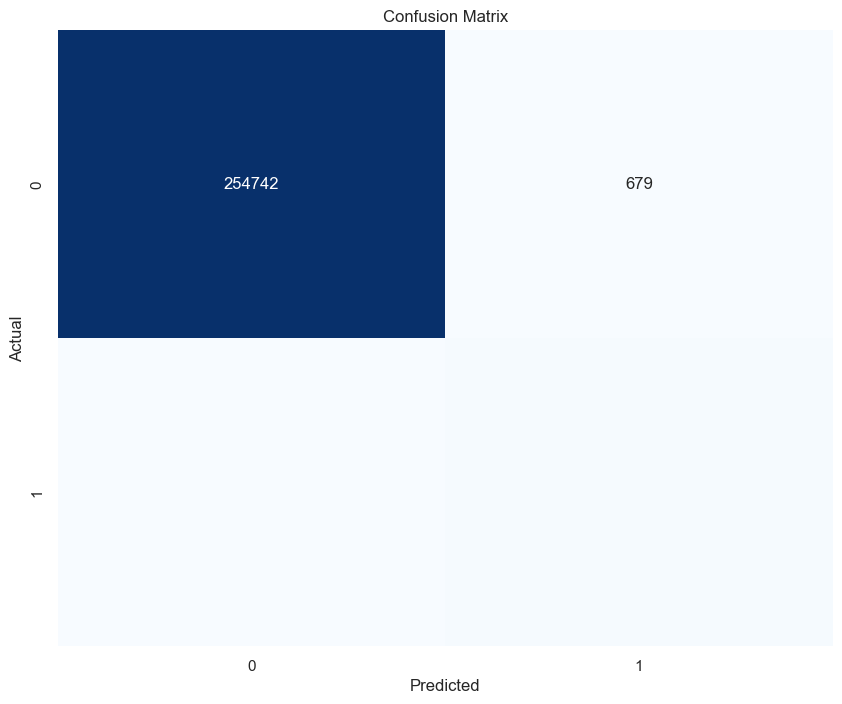


Classiifcation Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    255421
         1.0       0.77      1.00      0.87      2266

    accuracy                           1.00    257687
   macro avg       0.88      1.00      0.93    257687
weighted avg       1.00      1.00      1.00    257687



In [29]:
# print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix :\n", cm)

# calculate precision score
precision = precision_score(y_test, y_pred)
print("\n Precision score :", precision)

#Plot confusion matrix with light blue palette
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Display classification report
print("\nClassiifcation Report: ")
print(classification_report(y_test, y_pred))



#### **8.2 Logistic Regression**

In [30]:
from sklearn.linear_model import LogisticRegression

In [49]:
log_reg = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Train the model on scaled oversampled data
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test)

#Calcualte accuracy
accuracy_lr = log_reg.score(X_test,y_test)
accuracy_lr = accuracy_lr*100
print("\n Logistic Regression Accuracy :", accuracy_lr)


 Logistic Regression Accuracy : 99.52539320959148


 Confusion Matrxi :
 [[255405     16]
 [  1207   1059]]

Precision score : 0.9851162790697674


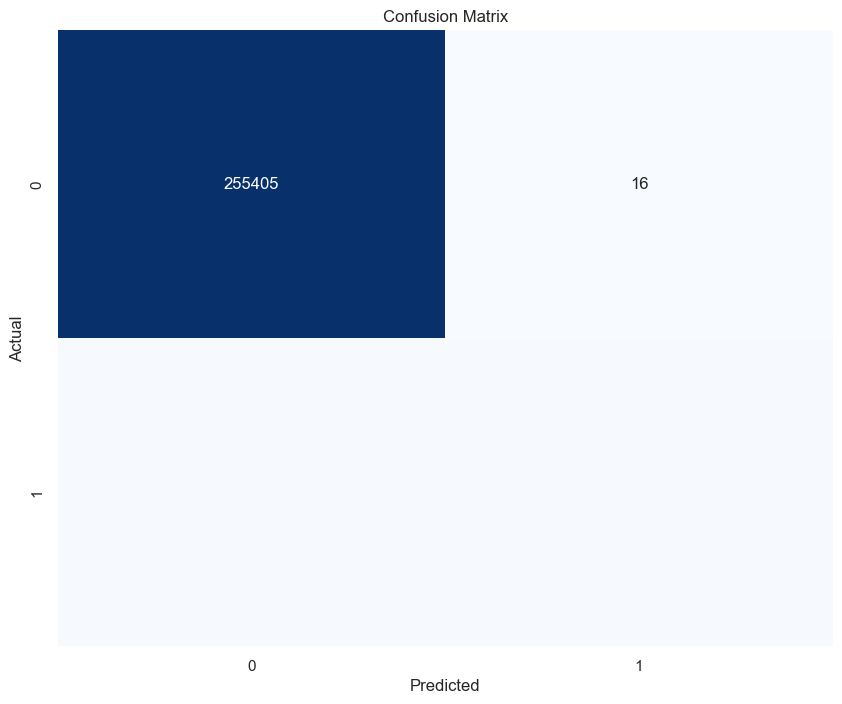


Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    255421
         1.0       0.99      0.47      0.63      2266

    accuracy                           1.00    257687
   macro avg       0.99      0.73      0.82    257687
weighted avg       1.00      1.00      0.99    257687



In [39]:
# Calculate confustion matrix
cm = confusion_matrix(y_test, y_pred)
print(" Confusion Matrxi :\n", cm)

# Calculate precision score
precision = precision_score(y_test, y_pred)
print("\nPrecision score :", precision)

#Plot confusion matrix with light blue palette
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#Display classification report
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

#### **8.3  Random Forest**

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
# Initialize Random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=13)

#Train model on oversampled data
rf.fit(X_train, y_train)

#Predict on test set
y_pred = rf.predict(X_test)

#Calcualate accuracy
accuracy_rf = rf.score(X_test, y_test)
accuracy_rf = accuracy_rf*100
print("\n Random Forest Accuracy: ", accuracy_rf*100)


 Random Forest Accuracy:  9972.136739532843


Confusion matrix: 
 [[254738    683]
 [    35   2231]]

Precision score : 0.7656142759094029


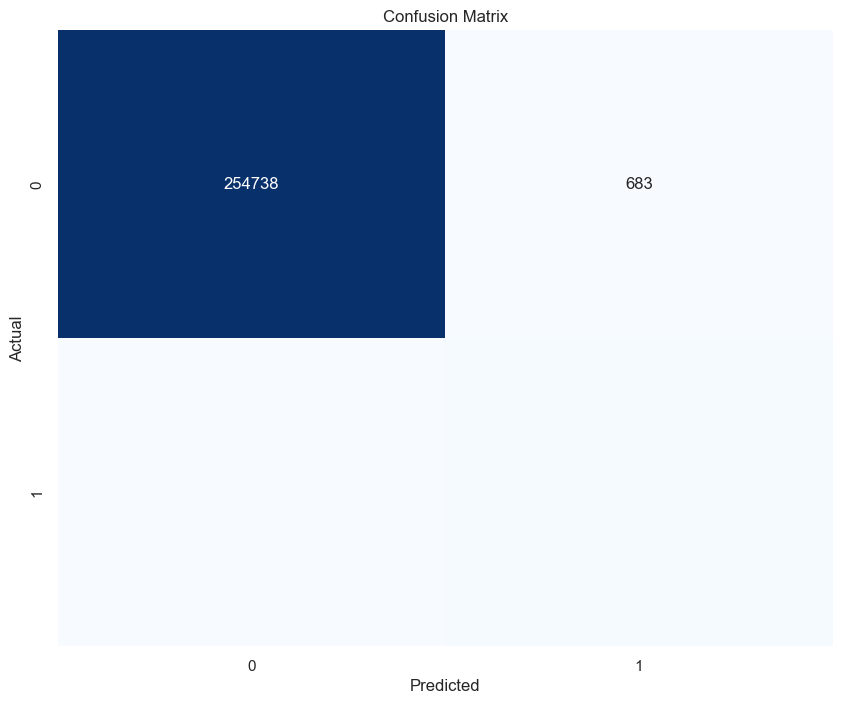


Classification Report :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    255421
         1.0       0.77      0.98      0.86      2266

    accuracy                           1.00    257687
   macro avg       0.88      0.99      0.93    257687
weighted avg       1.00      1.00      1.00    257687



In [44]:
#Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n", cm)

#Calculate precision score
precision = precision_score(y_test, y_pred)
print("\nPrecision score :", precision)

#plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report :\n", classification_report(y_test, y_pred))

### **9. Conclusion**

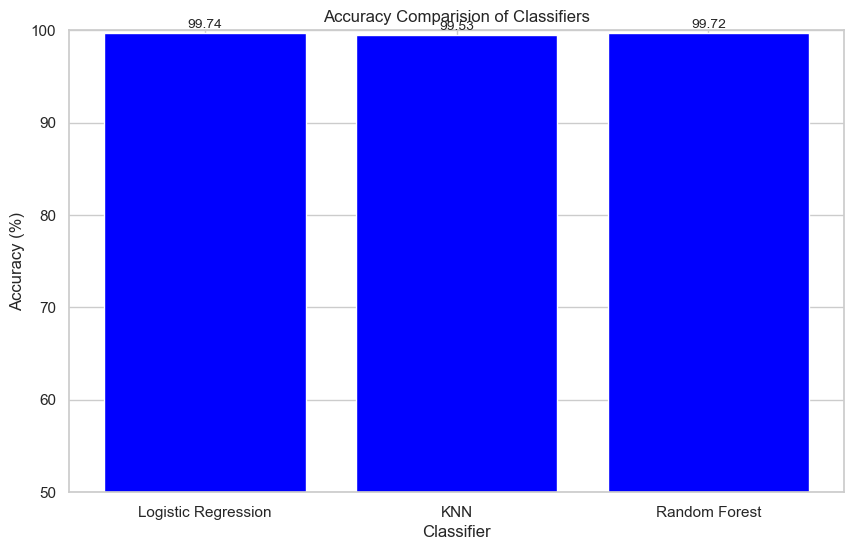

In [52]:
# Define the classifier and their accurasies

classifier = ['Logistic Regression', 'KNN', 'Random Forest']
accuracies = [accuracy_kn, accuracy_lr, accuracy_rf]

# plotting the bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(classifier, accuracies, color=['blue','blue','blue'])

# Adjust ylim to show differentce clearly
plt.ylim(50, 100)

plt.title('Accuracy Comparision of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')

# Displaying the accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.2, f'{accuracy:.2f}', ha='center', va='bottom',
             fontsize=10)

plt.show()